# XGBoost Training - Model Dataset


## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

from xgboost import XGBClassifier
from tqdm.auto import tqdm

import joblib
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load Data

In [2]:
df = pd.read_csv('model_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['facility_rating_status'].value_counts())
print(f"\nClass percentages:")
print(df['facility_rating_status'].value_counts(normalize=True) * 100)

Dataset shape: (65504, 59)

Target distribution:
facility_rating_status
0    55693
1     6711
2     3100
Name: count, dtype: int64

Class percentages:
facility_rating_status
0    85.022289
1    10.245176
2     4.732535
Name: proportion, dtype: float64


## 3. Prepare Features and Target

In [3]:
X = df.drop('facility_rating_status', axis=1)
y = df['facility_rating_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.shape[1]}")

Features shape: (65504, 58)
Target shape: (65504,)

Feature columns: 58


## 4. Train-Validation Split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nValidation target distribution:")
print(y_val.value_counts())

Training set: (52403, 58)
Validation set: (13101, 58)

Training target distribution:
facility_rating_status
0    44554
1     5369
2     2480
Name: count, dtype: int64

Validation target distribution:
facility_rating_status
0    11139
1     1342
2      620
Name: count, dtype: int64


In [16]:
# Check train-validation class distribution
print("CLASS DISTRIBUTION COMPARISON")
print("="*70)

# Original distribution
original_counts = y.value_counts().sort_index()
original_pct = (y.value_counts(normalize=True).sort_index() * 100)

print("\nOriginal Dataset:")
for cls in original_counts.index:
    print(f"  Class {cls}: {original_counts[cls]:>6,} samples ({original_pct[cls]:>5.2f}%)")
print(f"  Total:   {len(y):>6,} samples")

# Training distribution
train_counts = y_train.value_counts().sort_index()
train_pct = (y_train.value_counts(normalize=True).sort_index() * 100)

print("\nTraining Set (80%):")
for cls in train_counts.index:
    print(f"  Class {cls}: {train_counts[cls]:>6,} samples ({train_pct[cls]:>5.2f}%)")
print(f"  Total:   {len(y_train):>6,} samples")

# Validation distribution
val_counts = y_val.value_counts().sort_index()
val_pct = (y_val.value_counts(normalize=True).sort_index() * 100)

print("\nValidation Set (20%):")
for cls in val_counts.index:
    print(f"  Class {cls}: {val_counts[cls]:>6,} samples ({val_pct[cls]:>5.2f}%)")
print(f"  Total:   {len(y_val):>6,} samples")

# Comparison
print("\n" + "="*70)
print("STRATIFICATION")
print("="*70)
print(f"{'Class':<8} {'Original':<12} {'Training':<12} {'Validation':<12} {'Diff':<10}")
print("-"*70)

max_diff = 0
for cls in original_counts.index:
    diff = abs(train_pct[cls] - val_pct[cls])
    max_diff = max(max_diff, diff)
    print(f"{cls:<8} {original_pct[cls]:>6.2f}%{'':<5} {train_pct[cls]:>6.2f}%{'':<5} {val_pct[cls]:>6.2f}%{'':<5} {diff:>6.3f}%")



CLASS DISTRIBUTION COMPARISON

Original Dataset:
  Class 0: 55,693 samples (85.02%)
  Class 1:  6,711 samples (10.25%)
  Class 2:  3,100 samples ( 4.73%)
  Total:   65,504 samples

Training Set (80%):
  Class 0: 44,554 samples (85.02%)
  Class 1:  5,369 samples (10.25%)
  Class 2:  2,480 samples ( 4.73%)
  Total:   52,403 samples

Validation Set (20%):
  Class 0: 11,139 samples (85.02%)
  Class 1:  1,342 samples (10.24%)
  Class 2:    620 samples ( 4.73%)
  Total:   13,101 samples

STRATIFICATION
Class    Original     Training     Validation   Diff      
----------------------------------------------------------------------
0         85.02%       85.02%       85.02%       0.002%
1         10.25%       10.25%       10.24%       0.002%
2          4.73%        4.73%        4.73%       0.000%


## 5. Scale Features

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 6. Calculate Class Weights

In [6]:
class_counts = y_train.value_counts().sort_index()
total = len(y_train)
n_classes = len(class_counts)

class_weights = {}
for cls in class_counts.index:
    class_weights[cls] = total / (n_classes * class_counts[cls])

print("Class weights:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")

Class weights:
  Class 0: 0.3921
  Class 1: 3.2534
  Class 2: 7.0434


## 7. Baseline Model

In [7]:
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_baseline.fit(X_train_scaled, y_train)

y_pred = xgb_baseline.predict(X_val_scaled)
baseline_accuracy = accuracy_score(y_val, y_pred)

print(f"Baseline Validation Accuracy: {baseline_accuracy:.4f}")

Baseline Validation Accuracy: 0.9515


## 8. Hyperparameter Tuning

In [8]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

print(f"Testing {n_iter} parameter combinations")
print("Starting randomized search...\n")

pbar = tqdm(total=n_iter, desc="Tuning XGBoost")

best_score = 0
best_params = None
cv_results = []

for params in param_list:
    xgb = XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    scores = cross_val_score(xgb, X_train_scaled, y_train, 
                             cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    
    cv_results.append({
        'params': params,
        'cv_score': mean_score,
        'cv_std': scores.std()
    })
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    
    pbar.update(1)
    pbar.set_postfix({'best_cv_score': f'{best_score:.4f}'})

pbar.close()

print(f"\nBest CV Accuracy: {best_score:.4f}")
print(f"\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Testing 50 parameter combinations
Starting randomized search...



Tuning XGBoost:   0%|          | 0/50 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


Best CV Accuracy: 0.9526

Best parameters:
  subsample: 0.9
  n_estimators: 100
  min_child_weight: 1
  max_depth: 3
  learning_rate: 0.1
  gamma: 0.2
  colsample_bytree: 0.9


## 9. Train Final Model

In [9]:
xgb_tuned = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_tuned.fit(X_train_scaled, y_train)

print("Training complete")

Training complete


## 10. Validation Results

In [10]:
y_pred = xgb_tuned.predict(X_val_scaled)
y_pred_proba = xgb_tuned.predict_proba(X_val_scaled)

val_accuracy = accuracy_score(y_val, y_pred)
val_precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
val_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

print(f"Validation Metrics:")
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")

print(f"\nImprovement over baseline:")
print(f"  Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"  Tuned Accuracy:    {val_accuracy:.4f}")
print(f"  Improvement:       {val_accuracy - baseline_accuracy:+.4f}")

print(f"\nGeneralization:")
gen_gap = val_accuracy - best_score
print(f"  CV Accuracy:         {best_score:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f}")
print(f"  Gap:                 {gen_gap:+.4f}")

print(f"\nClassification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Validation Metrics:
  Accuracy:  0.9515
  Precision: 0.9531
  Recall:    0.9515
  F1-Score:  0.9477

Improvement over baseline:
  Baseline Accuracy: 0.9515
  Tuned Accuracy:    0.9515
  Improvement:       -0.0001

Generalization:
  CV Accuracy:         0.9526
  Validation Accuracy: 0.9515
  Gap:                 -0.0011

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11139
           1       0.98      0.71      0.82      1342
           2       0.98      0.64      0.77       620

    accuracy                           0.95     13101
   macro avg       0.97      0.78      0.86     13101
weighted avg       0.95      0.95      0.95     13101


Confusion Matrix:
[[11119    14     6]
 [  391   950     1]
 [  223     1   396]]


## 11. Save Model

In [ ]:
model_package = {
    'model': xgb_tuned,
    'model_name': 'XGBoost Multi-class Classifier',
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'best_params': best_params,
    'class_weights': class_weights,
    'training_performance': {
        'cv_accuracy': best_score,
        'baseline_accuracy': baseline_accuracy
    },
    'validation_performance': {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'n_samples': len(df),
        'n_features': X.shape[1],
        'n_classes': len(class_counts),
        'class_distribution': class_counts.to_dict()
    }
}

model_path = 'xgboost_multiclass_model.pkl'
joblib.dump(model_package, model_path)



## 12. Visualizations

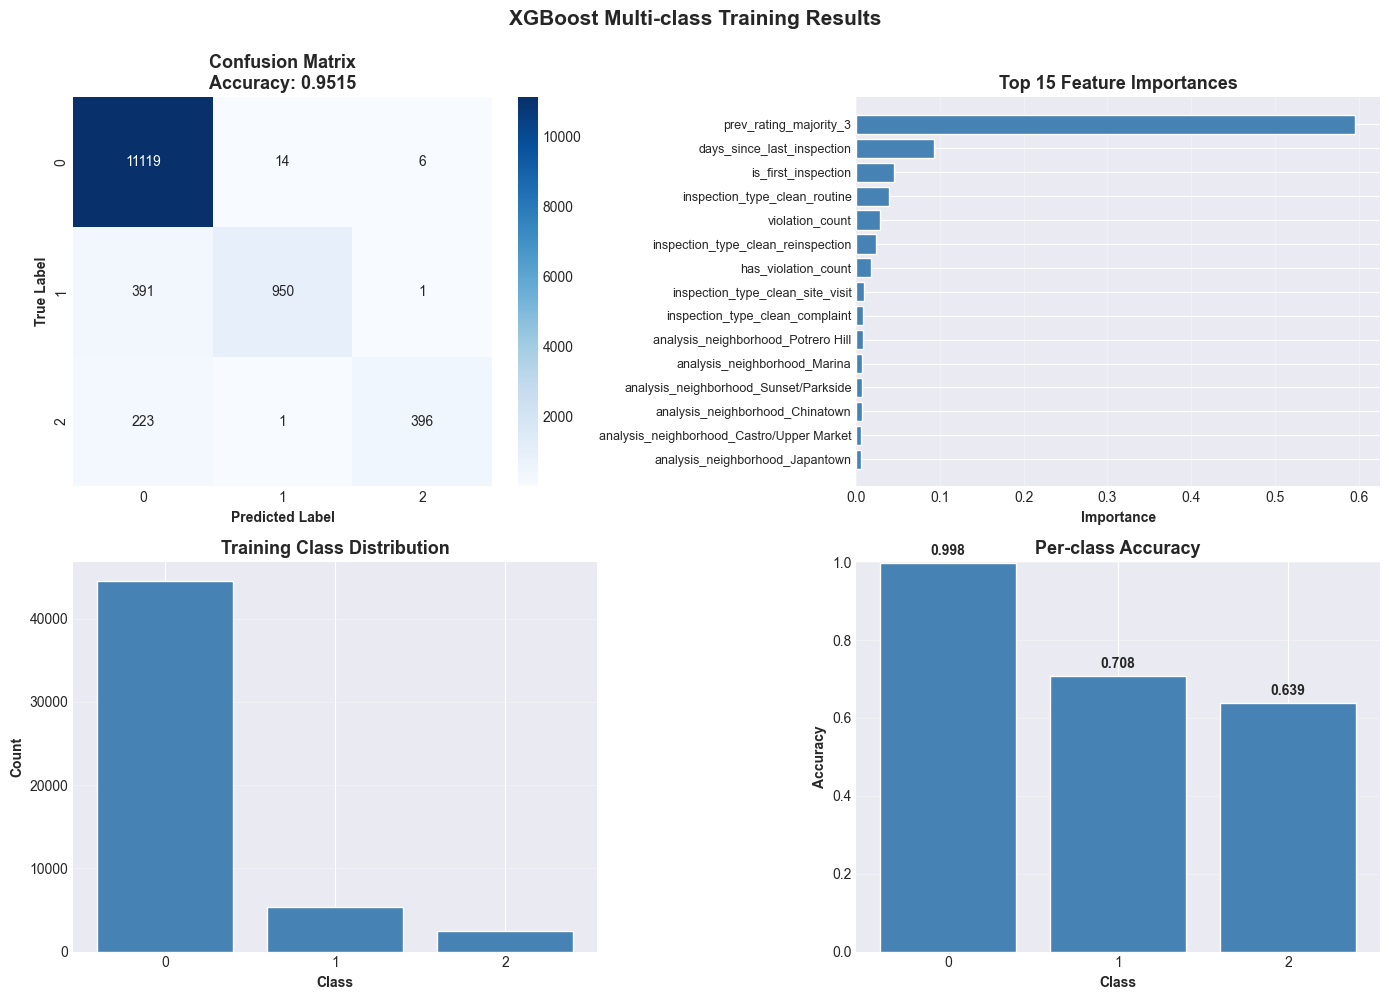

Visualization saved: XGBoost_Multiclass_Results.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
axes[0, 0].set_title(f'Confusion Matrix\nAccuracy: {val_accuracy:.4f}', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontweight='bold')

# Feature Importance
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)[-15:]
feature_names = X.columns.tolist()

axes[0, 1].barh(range(len(indices)), importances[indices], color='steelblue')
axes[0, 1].set_yticks(range(len(indices)))
axes[0, 1].set_yticklabels([feature_names[i] for i in indices], fontsize=9)
axes[0, 1].set_xlabel('Importance', fontweight='bold')
axes[0, 1].set_title('Top 15 Feature Importances', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Class Distribution
class_dist = y_train.value_counts().sort_index()
axes[1, 0].bar(class_dist.index, class_dist.values, color='steelblue')
axes[1, 0].set_xlabel('Class', fontweight='bold')
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].set_title('Training Class Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].grid(axis='y', alpha=0.3)

# Per-class Accuracy
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_acc = np.diag(cm_normalized)
axes[1, 1].bar([0, 1, 2], per_class_acc, color='steelblue')
axes[1, 1].set_xlabel('Class', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
axes[1, 1].set_title('Per-class Accuracy', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(per_class_acc):
    axes[1, 1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

plt.suptitle('XGBoost Multi-class Training Results', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('XGBoost_Multiclass_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: XGBoost_Multiclass_Results.png")